In [1]:
import numpy as np 
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def kpi(df):
    dem_ave = df.loc[df['Error'].notnull(),'Demand'].mean()
    bias_abs = df['Error'].mean()
    bias_rel = bias_abs / dem_ave
    print('Bias: {:0.2f}, {:.2%}'.format(bias_abs,bias_rel))
    MAPE = (df['Error'].abs()/df['Demand']).mean()
    print('MAPE: {:.2%}'.format(MAPE))
    MAE_abs = df['Error'].abs().mean()
    MAE_rel = MAE_abs / dem_ave
    print('MAE: {:0.2f}, {:.2%}'.format(MAE_abs,MAE_rel)) 
    RMSE_abs = np.sqrt((df['Error']**2).mean())
    RMSE_rel = RMSE_abs / dem_ave
    print('RMSE: {:0.2f}, {:.2%}'.format(RMSE_abs,RMSE_rel)) 

In [3]:
def seasonal_factors_mul(s,d,slen,cols):
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen]) # Season average
    s /= np.mean(s[:slen]) # Scale all season factors (sum of factors = slen)
    return s

In [4]:
def triple_exp_smooth_mul(d, slen=12, extra_periods=1, alpha=0.4, beta=0.4, phi=0.9, gamma=0.3):
    cols = len(d) # Historical pteriod length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    # components initialization
    f,a,b,s = np.full((4,cols+extra_periods),np.nan)
    s = seasonal_factors_mul(s,d,slen,cols)
    
     # Level & Trend initialization
    a[0] = d[0]/s[0]
    b[0] = d[1]/s[1]- d[0]/s[0]
    # Create the forecast for the first season
    for t in range(1,slen):
        f[t] = (a[t-1] + phi*b[t-1])*s[t]
        a[t] = alpha*d[t]/s[t] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
    # Create all the t+1 forecast
    for t in range(slen,cols):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = alpha*d[t]/s[t-slen] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*d[t]/a[t] + (1-gamma)*s[t-slen]
        # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = f[t]/s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]
    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a,'Trend':b, 'Season':s,'Error':d-f})
    return df


In [5]:
df = pd.read_csv('trimmed_data.csv')
d = np.array(df['Quantity'])

In [6]:
df2 = triple_exp_smooth_mul(d, slen=12, extra_periods=12, alpha=0.4, beta=0.25, phi=0.9, gamma=0.25)

In [9]:
df2['Demand']

0      2884.0
1      1885.0
2      1833.0
3      1300.0
4      1866.0
        ...  
128       NaN
129       NaN
130       NaN
131       NaN
132       NaN
Name: Demand, Length: 133, dtype: float64

<Axes: title={'center': 'Triple Exponential Model'}, xlabel='Period', ylabel='Volume'>

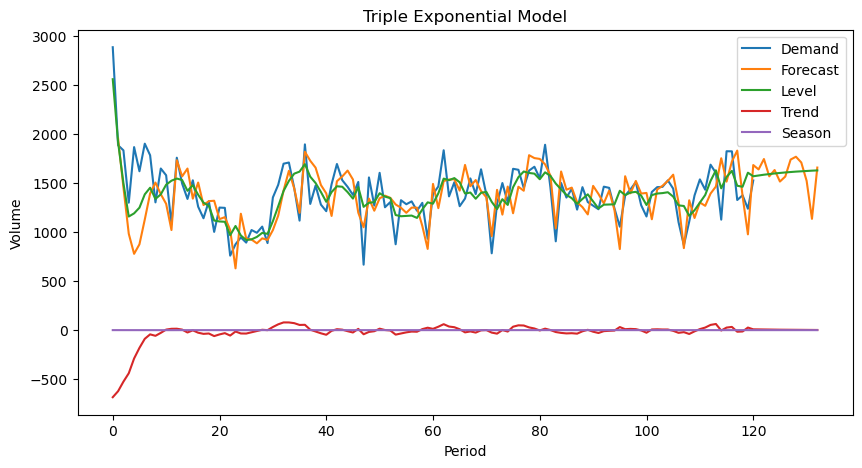

In [8]:
df2[['Demand','Forecast', 'Level', 'Trend','Season']].plot(figsize=(10,5),xlabel = 'Period', ylabel= 'Volume', title= 'Triple Exponential Model')


In [46]:
df2 = triple_exp_smooth_mul(d, slen=12, extra_periods=12, alpha=0.6, beta=0.3, phi=0.9, gamma=0.25)

<Axes: title={'center': 'XGBoost'}, xlabel='Period', ylabel='Volume'>

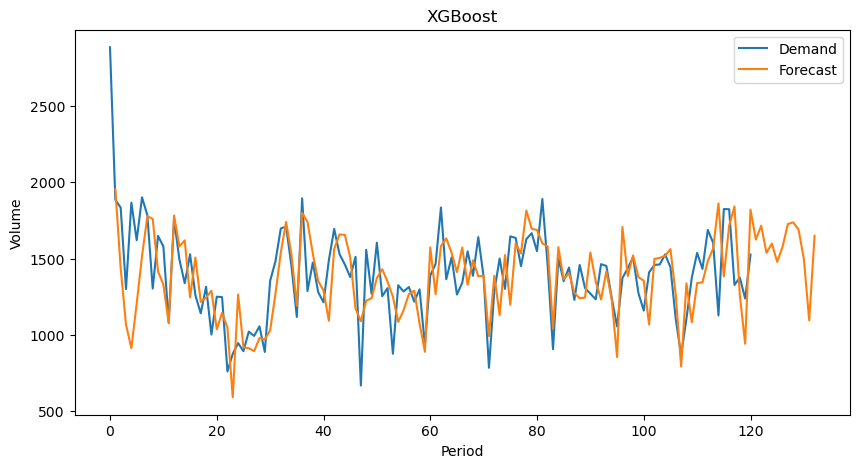

In [48]:
df2[['Demand','Forecast']].plot(figsize=(10,5),xlabel = 'Period', ylabel= 'Volume', title= 'XGBoost')


In [28]:
kpi(df2)

Bias: 1.84, 0.13%
MAPE: 19.41%
MAE: 256.41, 18.62%
RMSE: 333.34, 24.20%


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

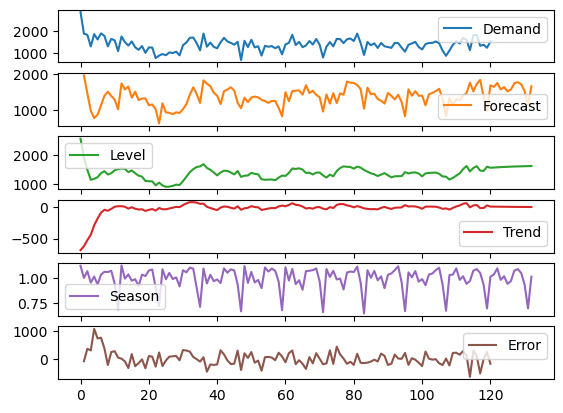

In [ ]:
df2.plot(subplots=True)

In [ ]:
kpi(df2)

Bias: 30.57, 2.22%
MAPE: 14.12%
MAE: 189.74, 13.77%
RMSE: 249.93, 18.14%


In [ ]:
m = df2['Error'].mean()
s = df2['Error'].std()
limit_high = norm.ppf(0.99,m,s) + df2['Forecast']

limit_low = norm.ppf(0.01,m,s) + df2['Forecast']
df2['Updated'] = df2['Demand'].clip(lower=limit_low,upper=limit_high)

In [ ]:

m = df2['Error'].mean()
s = df2['Error'].std()
prob = norm.cdf(df2['Error'], m, s)
#calculating mean and std without outliers
outliers = (prob > 0.99) | (prob < 0.01)
m2 = df2.loc[~outliers,'Error'].mean()
s2 = df2.loc[~outliers,'Error'].std()
limit_high = norm.ppf(0.99,m2,s2) + df2['Forecast']
limit_low = norm.ppf(0.01,m2,s2) + df2['Forecast']
df2['Updated'] = df2['Demand'].clip(lower=limit_low, upper=limit_high)

<Axes: title={'center': 'Car Sales'}, xlabel='Period'>

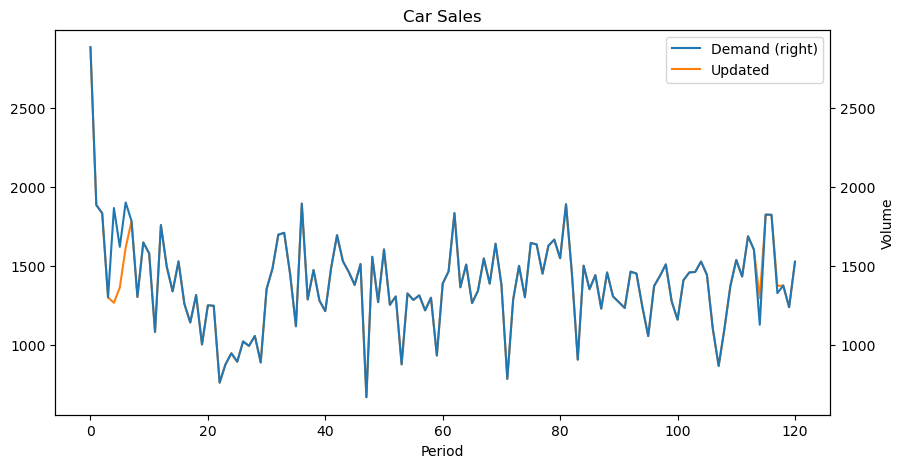

In [ ]:
df2[['Demand','Updated']].plot(figsize=(10,5),xlabel='Period',ylabel='Volume',title='Car Sales',secondary_y='Demand')